In [24]:
import xgboost
import shap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, learning_curve
from sklearn.metrics import confusion_matrix, make_scorer, cohen_kappa_score, log_loss
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import time
import pickle
from scipy import stats

# Data preprocessing

In [25]:
# the datasets are from DesignSafe
df0 = pd.read_csv('RF_YN_Model0.csv')
df3 = pd.read_csv('RF_YN_Model3.csv')
df5 = pd.read_csv('RF_YN_Model5.csv')

In [26]:
df0.head()

,Test ID,easting__N,northing__,GWD (m),L (m),Slope (%),Elevation,Target,CM pred
0,182,1577615.166,5181561.601,0.370809,319.116999,5.465739,0.909116,0,TN
1,15635,1577646.782,5182056.484,1.300896,211.770466,0.905948,1.123009,0,TN
2,8292,1577653.879,5182039.920,1.300896,195.947250,0.849104,0.847858,0,TN
3,15629,1577685.362,5181809.053,1.788212,115.795053,0.451034,2.044325,0,FP
4,183,1577700.888,5181709.124,1.637517,137.265348,0.941866,2.003797,1,TP


In [27]:
#trim outliers with IQR method
def trim_outliers(df):
    Q1 = df['Elevation'].quantile(0.25)
    Q3 = df['Elevation'].quantile(0.75)
    IQR = Q3-Q1
    print(f'IQR: {IQR:.2f}')
    trimming_matrix = (df['Elevation'] >= (Q1-1.5*IQR)) & (df['Elevation'] <= (Q3+1.5*IQR))
    df = df[trimming_matrix]
    return df

In [28]:
df0 = trim_outliers(df0)
df3 = trim_outliers(df3)
df5 = trim_outliers(df5)

IQR: 2.13
IQR: 2.13
IQR: 2.11


In [29]:
# these procedures are to make sure that the dataset compatible with the original script.
# insert the distance(km) column
df0.insert(5,'L (km)',df0['L (m)'].values/1000)
df3.insert(5,'L (km)',df3['L (m)'].values/1000)
df5.insert(5,'L (km)',df5['L (m)'].values/1000)

In [30]:
# drop unnecessary columns
df0 = df0.drop(['easting__N', 'northing__', 'L (m)', 'CM pred', 'Elevation'],axis=1)
df3 = df3.drop(['easting__N', 'northing__', 'L (m)', 'CM pred'],axis=1)
df5 = df5.drop(['easting__N', 'northing__', 'L (m)', '4m_Qtn_med', '4m_Qtn_std', 'CM pred'],axis=1)

## Split training, test and validation

In [31]:
#define features matrix (X) and target (y)
def split_data(df):
    X = df.copy(deep=True)
    y = df['Target']
    X_train_target, X_val_test_target, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=0)
    X_test_target, X_val_target, y_test, y_val = train_test_split(X_val_test_target, y_val_test, test_size=0.25, random_state=0)
    X_all = X.drop(['Test ID', 'Target'], axis=1)
    X_test = X_test_target.drop(['Test ID', 'Target'], axis = 1)
    X_train = X_train_target.drop(['Test ID', 'Target'], axis = 1)
    X_val = X_val_target.drop(['Test ID', 'Target'], axis = 1)
    return {'X':X, 'X_all':X_all, 'y':y,
            'X_train_target':X_train_target, 'X_train':X_train, 'y_train':y_train,
            'X_test_target':X_test_target, 'X_test':X_test, 'y_test':y_test,
            'X_val_target':X_val_target, 'X_val':X_val, 'y_val':y_val
           }


In [32]:
data0 = split_data(df0)
data3 = split_data(df3)
data5 = split_data(df5)

In [33]:
# Write data to pickle
file_path = 'xgb_models/'
pickle.dump(data0,open(file_path+'data0.pkl','wb'))
pickle.dump(data3,open(file_path+'data3.pkl','wb'))
pickle.dump(data5,open(file_path+'data5.pkl','wb'))

## Optimized model

In [17]:
def xgb_training(data, max_depth, n_estimators, eta):
    param_list = {'max_depth':max_depth,
                  'n_estimators':n_estimators,
                  'random_state':0,
                  'eval_metric':'logloss',
                  'eta':eta
                 }
    opt_xgb = xgboost.XGBClassifier(**param_list,use_label_encoder=False)
    opt_xgb.fit(data['X_train'], data['y_train'], eval_set=[(data['X_train'], data['y_train']), (data['X_val'], data['y_val'])], verbose=0)
    return opt_xgb



In [34]:
opt_xgb0 = xgb_training(data0, 5, 86, 0.131865)
opt_xgb3 = xgb_training(data3, 6, 25, 0.303344)
opt_xgb5 = xgb_training(data5, 5, 22, 0.286722)

#opt_xgb0 = xgb_training(data0, 9, 5, 0.192022)
#opt_xgb3 = xgb_training(data3, 9, 5, 0.192022)
#opt_xgb5 = xgb_training(data5, 9, 5, 0.192022)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [19]:
file_path = 'xgb_models/'

pickle.dump(opt_xgb0,open(file_path+'opt_XGB_YN0.pkl','wb'))
pickle.dump(opt_xgb3,open(file_path+'opt_XGB_YN3.pkl','wb'))
pickle.dump(opt_xgb5,open(file_path+'opt_XGB_YN5.pkl','wb'))

xgb0 = pickle.load(open('xgb_models/opt_XGB_YN0.pkl', 'rb'))
xgb3 = pickle.load(open('xgb_models/opt_XGB_YN3.pkl', 'rb'))
xgb5 = pickle.load(open('xgb_models/opt_XGB_YN5.pkl', 'rb'))

In [20]:
result0 = xgb0.evals_result()
result3 = xgb3.evals_result()
result5 = xgb5.evals_result()


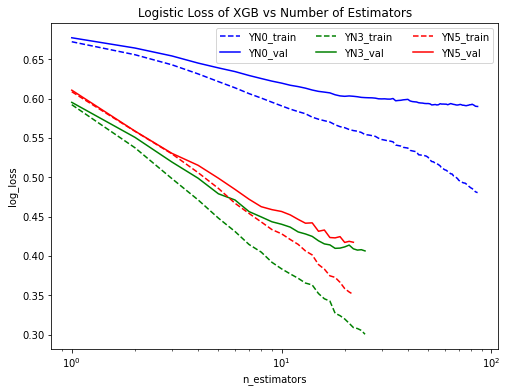

In [21]:
plt.figure(figsize=(8,6))
plt.plot(range(1,1+xgb0.n_estimators),result0['validation_0']['logloss'],'b--',label='YN0_train')
plt.plot(range(1,1+xgb0.n_estimators),result0['validation_1']['logloss'],'b',label='YN0_val')
plt.plot(range(1,1+xgb3.n_estimators),result3['validation_0']['logloss'],'g--',label='YN3_train')
plt.plot(range(1,1+xgb3.n_estimators),result3['validation_1']['logloss'],'g',label='YN3_val')
plt.plot(range(1,1+xgb5.n_estimators),result5['validation_0']['logloss'],'r--',label='YN5_train')
plt.plot(range(1,1+xgb5.n_estimators),result5['validation_1']['logloss'],'r',label='YN5_val')
plt.xlabel('n_estimators')
plt.xscale('log')
plt.ylabel('log_loss')
plt.legend(ncol=3)
#plt.yticks(np.arange(1, 9, 1)*0.25)
#plt.xlim(0.8,1000)
plt.title('Logistic Loss of XGB vs Number of Estimators')
plt.savefig('opt_XGB_loss.png')

In [22]:
for model_name, xgb, data in zip(['YN0','YN3','YN5'], [xgb0, xgb3, xgb5], [data0, data3, data5]):
    print(model_name)
    print('Training score: %.2f%%' %(xgb.score(data['X_train'], data['y_train']) * 100))
    print('Validation score: %.2f%%' %(xgb.score(data['X_val'], data['y_val']) * 100))
    print('Testing score: %.2f%%' %(xgb.score(data['X_test'], data['y_test']) * 100))
    print('Overall score: %.2f%%\n' %(xgb.score(data['X_all'], data['y']) * 100))

YN0
Training score: 77.92%
Validation score: 67.32%
Testing score: 68.67%
Overall score: 76.00%

YN3
Training score: 89.65%
Validation score: 79.44%
Testing score: 81.75%
Overall score: 87.95%

YN5
Training score: 86.49%
Validation score: 83.13%
Testing score: 81.54%
Overall score: 85.58%



pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

In [23]:
#make prediction
Y_pred_test = model.predict(X_test)
Y_pred_train = model.predict(X_train)
Y_pred_all = model.predict(X_all)

#assign class names
class_names=np.array(['No lateral spreading','Lateral spreading'], dtype='U25')

# Plot non-normalized confusion matrix for training dataset
np.set_printoptions(precision=2)
plots.plot_confusion_matrix(y_train, Y_pred_train, classes=class_names,
                      title='Confusion matrix, without normalization - Train')

# Plot normalized confusion matrix for training dataset
plots.plot_confusion_matrix(y_train, Y_pred_train, classes=class_names, normalize=True,
                      title='Normalized confusion matrix - Train')

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix for testing dataset
plots.plot_confusion_matrix(y_test, Y_pred_test, classes=class_names,
                      title='Confusion matrix, without normalization - Test')

# Plot normalized confusion matrix for testing dataset
plots.plot_confusion_matrix(y_test, Y_pred_test, classes=class_names, normalize=True,
                      title='Normalized confusion matrix - Test')
plt.show()


# Plot non-normalized confusion matrix for whole dataset
plots.plot_confusion_matrix(y, Y_pred_all, classes=class_names,
                      title='Confusion matrix, without normalization - All')

# Plot normalized confusion matrix for whole dataset
plots.plot_confusion_matrix(y, Y_pred_all, classes=class_names, normalize=True,
                      title='Normalized confusion matrix - All')
plt.show()

NameError: name 'model' is not defined